In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from sqlalchemy import create_engine
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from PIL import Image

In [10]:
engine = create_engine('sqlite:///pba.db')
with engine.connect() as conn:
    df_player = pd.read_sql('SELECT * FROM player', con=conn)
    df_avg_stat = pd.read_sql('SELECT * FROM avg_stat', con=conn)
    df_tot_stat = pd.read_sql('SELECT * FROM total_stat', con=conn)
    df_team = pd.read_sql('SELECT * FROM team', con=conn)
    df_team_avg_stat = pd.read_sql('SELECT * FROM team_avg_stat', con=conn)
    df_team_tot_stat = pd.read_sql('SELECT * FROM team_total_stat', con=conn)
    df_history = pd.read_sql('SELECT * FROM history', con=conn)
    df_conference = pd.read_sql('SELECT * FROM conference', con=conn)
    
engine.dispose()

In [88]:
def get_total_stat():
    """Return all total stat"""
    df_all_total = (pd.merge(df_tot_stat.add_prefix('ply_'),
                             df_team_tot_stat.add_prefix('tm_'), how='left',
                             left_on=['ply_team_id', 'ply_hist_id'],
                             right_on=['tm_team_id', 'tm_hist_id']))
    return df_all_total


def get_total_data():
    """Return all average data"""
    df_all_total = get_total_stat()
    return get_allstat_with_name(df_all_total)


def get_average_stat():
    """Return all average stat"""
    df_all_average = (pd.merge(df_avg_stat.add_prefix('ply_'),
                               df_team_avg_stat.add_prefix('tm_'), how='left',
                               left_on=['ply_team_id', 'ply_hist_id'],
                               right_on=['tm_team_id', 'tm_hist_id']))
    return df_all_average


def get_average_data():
    """Return all average data"""
    df_all_average = get_average_stat()

    return get_allstat_with_name(df_all_average)


def get_all_stat():
    """Return all stat values"""
    df_all_total = get_total_stat()
    df_all_average = get_average_stat()
    df_all_stat = pd.merge(df_all_average, df_all_total,
                           on=['ply_team_id', 'ply_hist_id', 'ply_player_id'],
                           how='inner',
                           suffixes=['_avg', '_total'])
    return df_all_stat


def get_all_data():
    """Return all the data"""
    df_all_stat = get_all_stat()
    return get_allstat_with_name(df_all_stat)


def get_playerstat_with_name(df_stat):
    """Return df_stat with name of the foreign keys"""
    all_cols = [col for col in df_stat.columns
                if ('id' not in col) & ('index' not in col)]
    all_cols.insert(1, 'year')
    all_cols.insert(2, 'conference')
    all_cols.insert(3, 'player_name')
    all_cols.insert(4, 'team_name')
    df_all_year = pd.merge(df_stat, df_history, how='inner',
                           left_on='hist_id', right_on='index')
    df_all_conf = pd.merge(df_all_year, df_conference, how='left',
                           left_on='conference_id', right_on='index')
    df_all_player = pd.merge(df_all_conf, df_player, how='left',
                             left_on='player_id', right_on='index')
    df_all_named = pd.merge(df_all_player, df_team, how='left',
                            left_on='team_id', right_on='index')
    return df_all_named[all_cols]


def get_teamstat_with_name(df_stat):
    """Return df_stat with name of the foreign keys"""
    all_cols = [col for col in df_stat.columns
                if ('id' not in col) & ('index' not in col)]
    all_cols.insert(1, 'year')
    all_cols.insert(2, 'conference')
    all_cols.insert(3, 'team_name')
    df_all_year = pd.merge(df_stat, df_history, how='inner',
                           left_on='hist_id', right_on='index')
    df_all_conf = pd.merge(df_all_year, df_conference, how='left',
                           left_on='conference_id', right_on='index')
    df_all_named = pd.merge(df_all_conf, df_team, how='left',
                            left_on='team_id', right_on='index')
    return df_all_named[all_cols]


def get_allstat_with_name(df_stat):
    """Return df_stat (Average + Total) with name of the foreign keys"""
    all_cols = [col for col in df_stat.columns
                if ('id' not in col) & ('index' not in col)]
    all_cols.insert(1, 'year')
    all_cols.insert(2, 'conference')
    all_cols.insert(3, 'player_name')
    all_cols.insert(4, 'team_name')
    df_all_year = pd.merge(df_stat, df_history, how='inner',
                           left_on='ply_hist_id', right_on='index')
    df_all_conf = pd.merge(df_all_year, df_conference, how='left',
                           left_on='conference_id', right_on='index')
    df_all_player = pd.merge(df_all_conf, df_player, how='left',
                             left_on='ply_player_id', right_on='index')
    df_all_named = pd.merge(df_all_player, df_team, how='left',
                            left_on='ply_team_id', right_on='index')
    return df_all_named[all_cols]

In [91]:
get_all_data()

,ply_GP_avg,year,conference,player_name,team_name,ply_MIN_avg,ply_FGm_avg,ply_FGa_avg,ply_FG%_avg,ply_3Pm_avg,...,tm_TO_total,tm_PTO_total,tm_PF_total,tm_FBm_total,tm_FBa_total,tm_FBm%_total,tm_bPTS_total,tm_PTS_total,tm_W_total,tm_L_total
0,11,2017,GOV,L. Henton,ALA,41.81,10.18,24.09,0.42,2.91,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3,8
1,8,2017,GOV,C. Abueva,ALA,28.19,5.50,14.25,0.39,0.38,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3,8
2,11,2017,GOV,J. Casio,ALA,23.81,3.82,8.00,0.48,1.27,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3,8
3,10,2017,GOV,C. Banchero,ALA,23.40,3.60,9.30,0.39,0.60,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3,8
4,8,2017,GOV,V. Manuel,ALA,16.89,3.38,8.50,0.40,0.00,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,1,2020,PH,R. Escoto,SMB,11.52,1.00,2.00,0.50,0.00,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.0,1,0
1418,1,2020,PH,P. Zamar,SMB,4.52,1.00,1.00,1.00,1.00,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.0,1,0
1419,1,2020,PH,R. Gamalinda,SMB,5.57,0.00,0.00,0.00,0.00,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.0,1,0
1420,1,2020,PH,V. Pessumal,SMB,9.65,0.00,1.00,0.00,0.00,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.0,1,0


In [95]:
get_playerstat_with_name(df_tot_stat)

,GP,year,conference,player_name,team_name,MIN,FGm,FGa,FG%,3Pm,...,APG,STL,BLK,oREB,dREB,REB,PF,TOV,+/-,PTS
0,11,2017,GOV,L. Henton,ALA,459.88,112,265,0.42,32,...,26,18,23,34,95,129,20,39,-49,309
1,8,2017,GOV,C. Abueva,ALA,225.48,44,114,0.39,3,...,18,10,8,29,56,85,19,24,-4,120
2,11,2017,GOV,J. Casio,ALA,261.86,42,88,0.48,14,...,40,10,2,4,30,34,25,17,-11,113
3,10,2017,GOV,C. Banchero,ALA,233.96,36,93,0.39,6,...,31,9,2,14,24,38,25,23,-79,93
4,8,2017,GOV,V. Manuel,ALA,135.11,27,68,0.40,0,...,2,3,2,9,29,38,13,6,-27,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,1,2020,PH,R. Escoto,SMB,11.52,1,2,0.50,0,...,0,0,0,3,2,5,2,2,-8,3
1418,1,2020,PH,P. Zamar,SMB,4.52,1,1,1.00,1,...,0,0,0,0,0,0,0,0,-4,3
1419,1,2020,PH,R. Gamalinda,SMB,5.57,0,0,0.00,0,...,0,1,0,0,0,0,0,1,-6,0
1420,1,2020,PH,V. Pessumal,SMB,9.65,0,1,0.00,0,...,0,0,0,0,0,0,0,0,-3,0


In [97]:
get_teamstat_with_name(df_team_avg_stat)

,GP,year,conference,team_name,3Pm,3Pa,3P%,2Pm,2Pa,2P%,...,TO,PTO,PF,FBm,FBa,FBm%,bPTS,PTS,W,L
0,23,2017,GOV,GIN,7.65,22.48,0.34,30.35,60.70,0.50,...,17.30,17.09,19.17,5.39,6.00,9.52,29.00,99.52,16,7
1,23,2017,GOV,MER,9.96,27.87,0.36,25.74,55.00,0.47,...,15.43,15.30,21.04,6.43,7.13,11.83,25.87,94.83,16,7
2,17,2017,GOV,TNT,10.47,33.59,0.31,28.35,55.06,0.51,...,17.12,17.12,25.65,7.35,8.24,13.41,27.94,105.35,10,7
3,13,2017,GOV,ROS,12.23,36.46,0.34,25.54,51.46,0.50,...,17.69,18.62,23.54,6.46,7.08,11.54,45.08,101.85,8,5
4,15,2017,GOV,MAG,7.47,23.80,0.31,29.73,61.13,0.49,...,15.67,21.20,23.20,7.07,7.47,13.27,42.60,96.07,8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,11,2019,PH,COL,9.09,28.64,0.32,25.36,55.00,0.46,...,16.55,18.45,25.27,7.64,8.27,14.00,45.00,94.36,4,7
82,11,2019,PH,MER,8.55,29.73,0.29,25.09,55.00,0.46,...,13.55,14.73,23.27,5.00,5.18,8.82,40.64,90.00,3,8
83,11,2019,PH,BWE,7.82,25.64,0.30,26.73,60.09,0.44,...,16.36,18.00,22.82,7.36,8.09,13.55,43.45,92.82,2,9
84,1,2020,PH,SMB,12.00,32.00,0.38,25.00,44.00,0.57,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.00,1,0


In [96]:
chkcol = sum([1 if x else 0 for x in get_teamstat_with_name(df_team_avg_stat).isnull().any()])
print('There are {} columns with NaN'.format(chkcol))


There are 0 columns with NaN


# Word Cloud Player Frequency

In [20]:
def display_wc_player_freq():
    """Show playername Wordcloud based on minutes"""
    # Get player frequency
    engine = create_engine('sqlite:///pba.db')
    with engine.connect() as conn:
        df_player_total_mins = pd.read_sql("""SELECT p.player_name, ts.`MIN`
                                                FROM player p
                                                INNER JOIN total_stat ts
                                                ON p.`index` = ts.player_id
                                            """,
                                           con=conn)
    engine.dispose()
    df_player_total_mins.MIN = (df_player_total_mins.MIN
                                .apply(lambda x: round(x)))
    df_player_total_mins['last_name'] = (df_player_total_mins.player_name
                                     .apply(lambda x: x.split('. ')[1]))
    # Sum total frequency per conference
    player_freq = (df_player_total_mins.groupby('last_name')
               .sum().squeeze().to_dict())
    pba_mask = np.array(Image.open('pba_logo_wc.png'))
    # Word Cloud
    wc = WordCloud(mask=pba_mask, random_state=40, relative_scaling=0, 
                  background_color="white", regexp=r'\b[a-zA-Z]+?\b',
                   repeat=False)

    wc.generate_from_frequencies(player_freq)

    image_colors = ImageColorGenerator(pba_mask)
    wc.recolor(color_func=image_colors)
    plt.figure(figsize=(20, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off');

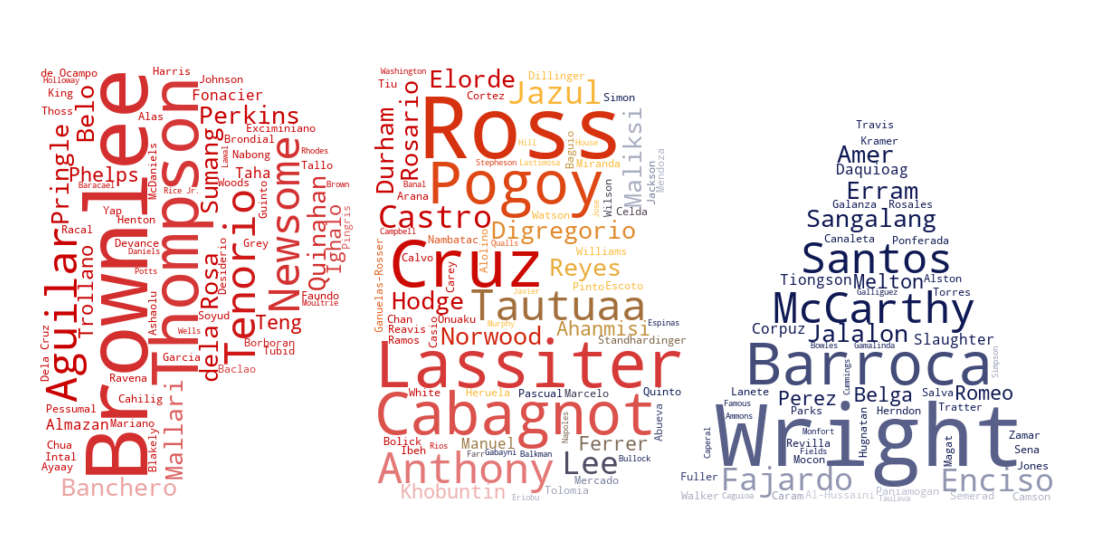

In [21]:
display_wc_player_freq()

# Hierarchical Clustering Team

## Average Team Statistics

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD

In [23]:
feature = StandardScaler().fit_transform(df_team_avg_stat.iloc[:, 3:])

In [ ]:
def lsa
fig, ax = plt.subplots(figsize=(9, 8))
ax.plot(range(1, len(nssd_ng)+1), nssd_ng, '-', label='individual')
ax.set_xlim(0, len(nssd_ng)+1)
ax.set_xlabel('SV')
ax.set_ylabel('variance explained')
ax = ax.twinx()
ax.plot(range(1, len(nssd_ng)+1), nssd_ng.cumsum(), 'r-', label='cumulative')
ax.axhline(0.9, ls='--', color='g')
ax.axvline(662, ls='--', color='g')
ax.set_ylabel('cumulative variance explained');

### Explore Dimensionality Reduction

In [27]:
pca = PCA(10).fit(feature)